# Analysis of Employee Attrition

### PREPARED BY CODY BALDWIN

It has been estimated that, when an employee leaves (voluntarily or involuntarily), it costs 1.5x their salary to replace them.  Those costs include time spent by (1) recruiters who identify job candidates, (2) existing employees who vet and interview those candidates, and (3) new employees who undergo training to "get up to speed."  **In this analysis, I attempt to (1) understand and predict employee attrition at company XYZ and (2) offer recommendations for addressing attrition based on the data analysis and additional research.**

This report will be broken down into five sections:

- Part 1: Load and explore the dataset.
- Part 2: Graph the dataset.
- Part 3: Prepare the data for modeling.
- Part 4: Build and evaluate models for predicting attrition.
- Part 5: Offer recommendations for addressing attrition.


### PART 1: LOAD AND EXPLORE THE DATASET

Prior to beginning our analysis, we need to load the dataset and the appropriate R code libraries and then explore the data.

In [ ]:
# Load the appropriate R code libraries.
shh <- suppressPackageStartupMessages
shh(library(ggplot2))
shh(library(ggcorrplot))
shh(library(caret))
shh(library(pROC))
shh(library(rpart))
shh(library(randomForest))

# Set standard dimensions for plots.
options(repr.plot.width=3.5, repr.plot.height=3)

In [ ]:
# Load the CSV file containing employee data into a data frame.
hr_data <- read.csv('http://bit.ly/employee_data')

**The output below shows all the columns in the dataset.**  Attrition, which is ultimately what we want to predict, is listed first.  (0 indicates the employee stayed.  1 indicates they left.)  Other variables, which may be beneficial in making that prediction (such as the employee's age, income, and department), are listed after attrition. 

In [ ]:
# Count the number of rows, and list the columns and their data types.
str(hr_data)

'data.frame':	1470 obs. of  25 variables:
 $ Attrition              : int  1 0 1 0 0 0 0 0 0 0 ...
 $ EmployeeNumber         : int  1 2 4 5 7 8 10 11 12 13 ...
 $ Age                    : int  41 49 37 33 27 32 59 30 38 36 ...
 $ Gender                 : Factor w/ 2 levels "Female","Male": 1 2 2 1 2 2 1 2 2 2 ...
 $ MaritalStatus          : Factor w/ 3 levels "Divorced","Married",..: 3 2 3 2 2 3 2 1 3 2 ...
 $ Department             : Factor w/ 3 levels "Human Resources",..: 3 2 2 2 2 2 2 2 2 2 ...
 $ JobRole                : Factor w/ 9 levels "Healthcare Representative",..: 8 7 3 7 3 3 3 3 5 1 ...
 $ MonthlyIncome          : int  5993 5130 2090 2909 3468 3068 2670 2693 9526 5237 ...
 $ OverTime               : Factor w/ 2 levels "No","Yes": 2 1 2 2 1 1 2 1 1 1 ...
 $ EducationField         : Factor w/ 6 levels "Human Resources",..: 2 2 5 2 4 2 4 2 2 4 ...
 $ BusinessTravel         : Factor w/ 3 levels "Non-Travel","Travel_Frequently",..: 3 2 3 2 3 2 3 3 2 3 ...
 $ DistanceFromHome   

In [ ]:
# Preview the first few records in the data frame.
head(hr_data)

Attrition,EmployeeNumber,Age,Gender,MaritalStatus,Department,JobRole,MonthlyIncome,OverTime,EducationField,...,PerformanceRating,PercentSalaryHike,StockOptionLevel,TrainingTimesLastYear,TotalWorkingYears,NumCompaniesWorked,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,1,41,Female,Single,Sales,Sales Executive,5993,Yes,Life Sciences,...,3,11,0,0,8,8,6,4,0,5
0,2,49,Male,Married,Research & Development,Research Scientist,5130,No,Life Sciences,...,4,23,1,3,10,1,10,7,1,7
1,4,37,Male,Single,Research & Development,Laboratory Technician,2090,Yes,Other,...,3,15,0,3,7,6,0,0,0,0
0,5,33,Female,Married,Research & Development,Research Scientist,2909,Yes,Life Sciences,...,3,11,0,3,8,1,8,7,3,0
0,7,27,Male,Married,Research & Development,Laboratory Technician,3468,No,Medical,...,3,12,1,3,6,9,2,2,2,2
0,8,32,Male,Single,Research & Development,Laboratory Technician,3068,No,Life Sciences,...,3,13,0,2,8,0,7,7,3,6


In [ ]:
# Generate descriptive stats for each column.
summary(hr_data)

   Attrition      EmployeeNumber        Age           Gender     MaritalStatus
 Min.   :0.0000   Min.   :   1.0   Min.   :18.00   Female:588   Divorced:327  
 1st Qu.:0.0000   1st Qu.: 491.2   1st Qu.:30.00   Male  :882   Married :673  
 Median :0.0000   Median :1020.5   Median :36.00                Single  :470  
 Mean   :0.1612   Mean   :1024.9   Mean   :36.92                              
 3rd Qu.:0.0000   3rd Qu.:1555.8   3rd Qu.:43.00                              
 Max.   :1.0000   Max.   :2068.0   Max.   :60.00                              
                                                                              
                  Department                       JobRole    MonthlyIncome  
 Human Resources       : 63   Sales Executive          :326   Min.   : 1009  
 Research & Development:961   Research Scientist       :292   1st Qu.: 2911  
 Sales                 :446   Laboratory Technician    :259   Median : 4919  
                              Manufacturing Director   :

### PART 2: GRAPH THE DATASET

Prior to building a predictive model, we graph the dataset to better understand attrition and to answer several questions that have been posed by management.  The graphs below are organized by those questions, which are the following:

- Q1: "Does one gender tend to quit more frequently than the other?"
- Q2: "Does age appear to make a difference?  Are our younger workers less committed to our company?"
- Q3: "Are we working our employees too hard? Is our overtime requirement for some employees driving them away?"
- Q4: "Is this about money? Are we not paying employees enough? Were the raises not strong enough? Is that why they leave?"
- Q5: "Our concern is that the highest performing employees are leaving at a higher rate. Is that true?"

#### QUESTION #1:  "Does one gender tend to quit more frequently than the other?"

Based on the charts below, there does NOT appear to be significant differences in attrition based on gender.  Even though a higher *number* of male employees left the company (the first chart), this should be offset by the fact that we have more male employees than female employees.  We would do better to review the attrition *percentage* by gender (the second chart).  Those percentages are nearly identical.

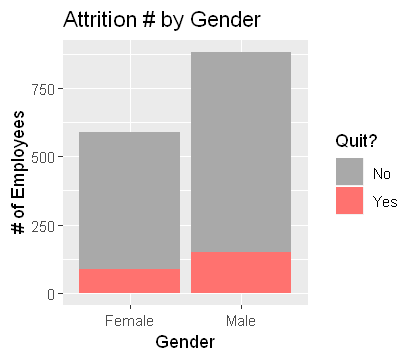

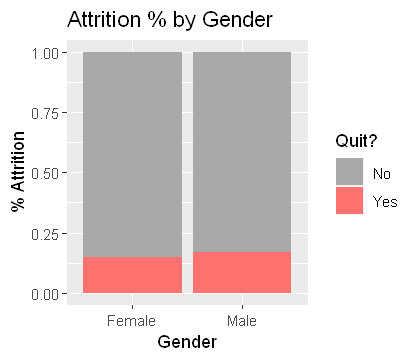

In [ ]:
# Create a bar plot that counts employees by gender and attrition.
ggplot(hr_data, aes(x = Gender, fill = factor(Attrition))) +
    geom_bar() +
    ggtitle("Attrition # by Gender") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    ylab("# of Employees")

# Create a bar plot that shows % attrition by  gender.
ggplot(hr_data, aes(x = Gender, fill = factor(Attrition))) +
    geom_bar(position = "fill") +
    ggtitle("Attrition % by Gender") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    ylab("% Attrition")

#### QUESTION #2:  "Does age appear to make a difference?  Are our younger workers less committed to our company?"

Based on the charts below, it appears that younger employees tend to leave at higher rates.  However, we CANNOT say that this is caused by younger employees being less committed to the company.  More research would be needed to make this determination.

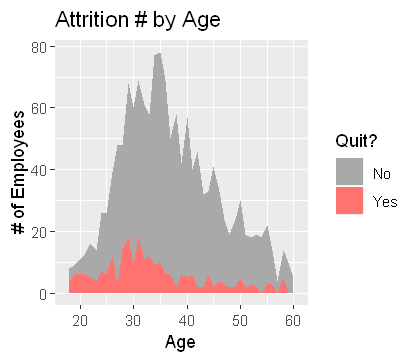

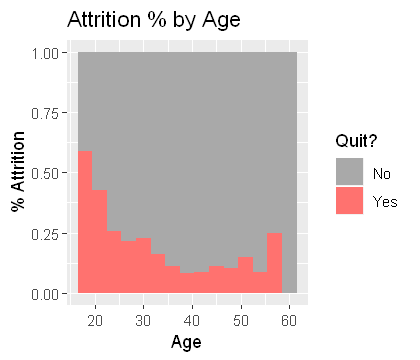

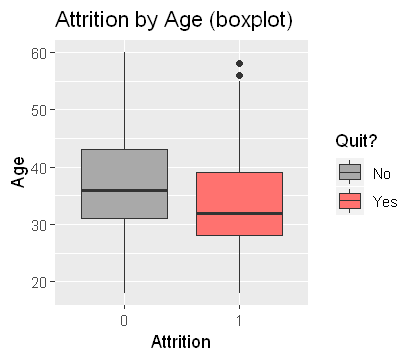

In [ ]:
# Create an area chart that counts employees by age and attrition.
ggplot(hr_data, aes(x = Age)) +
    geom_area(aes(fill = factor(Attrition)), stat="bin", binwidth=1) + 
    ggtitle("Attrition # by Age") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    ylab("# of Employees")

# Create a bar plot that shows % attrition by age.
ggplot(hr_data, aes(x=Age, fill = factor(Attrition))) +
    geom_histogram(binwidth=3, position='fill') + 
    ggtitle("Attrition % by Age") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    ylab("% Attrition")

# Create a box plot to show the distribution of ages by attrition status.
ggplot(hr_data, aes(x = factor(Attrition), y = Age)) + 
    geom_boxplot(aes(fill = factor(Attrition))) +
    ggtitle("Attrition by Age (boxplot)") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    xlab("Attrition")

#### QUESTION #3:  "Are we working our employees too hard?  Is our overtime requirement for some employees driving them away?"

Based on the chart below, those employees who are required to work overtime DO tend to leave at higher rates.  However, more research would be needed to determine whether or not this is the actual cause of their departure.  There appears to be some relationship, though. between overtime requirements and attrition.

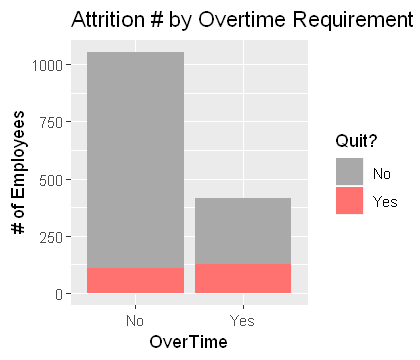

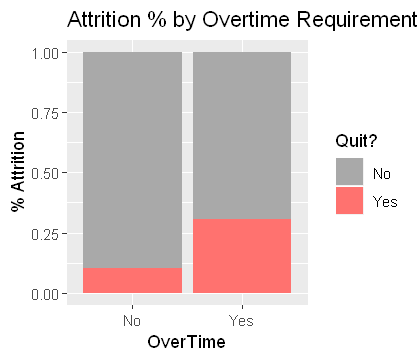

In [ ]:
# Create a bar plot that counts employees by overtime requirement and attrition.
ggplot(hr_data, aes(x=OverTime, fill = factor(Attrition))) +
    geom_bar() +
    ggtitle("Attrition # by Overtime Requirement") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    ylab("# of Employees")

# Create a bar plot that shows % attrition by overtime requirement.
ggplot(hr_data, aes(x=OverTime, fill = factor(Attrition))) +
    geom_bar(position = "fill") +
    ggtitle("Attrition % by Overtime Requirement") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    ylab("% Attrition")

#### QUESTION #4: "Is this about money?  Are we not paying employees enough?  Were the raises not strong enough?  Is that why they leave?"

Based on the chart, it appears that employees who get paid less tend to leave at higher rates.  There appears to be at least some correlation between income and attrition.  (Correlation, not necessarily causation.)

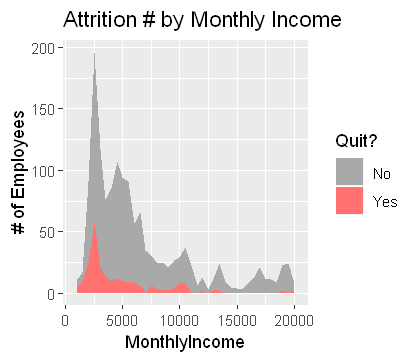

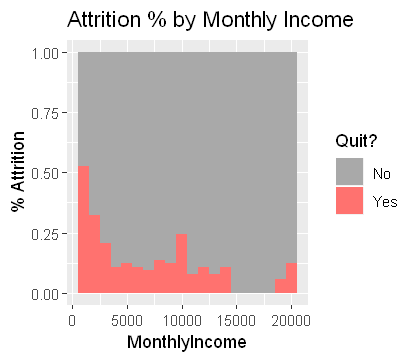

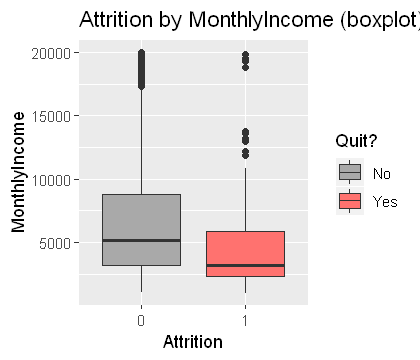

In [ ]:
# Create an area chart that counts employees by monthly income and attrition.
ggplot(hr_data,aes(x = MonthlyIncome)) +
    geom_area(aes(fill = factor(Attrition)), stat="bin", binwidth=500) +
    ggtitle("Attrition # by Monthly Income") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    ylab("# of Employees")

# Create a histogram that shows % attrition by monthly income.
ggplot(hr_data, aes(x = MonthlyIncome, fill = factor(Attrition))) +
    geom_histogram(binwidth = 1000, position = "fill") +
    ggtitle("Attrition % by Monthly Income") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) +  
    ylab("% Attrition")

# Create a box plot to show the distribution of monthly income by attrition status.
ggplot(hr_data, aes(x = factor(Attrition), y = MonthlyIncome)) + 
    geom_boxplot(aes(fill = factor(Attrition))) +
    ggtitle("Attrition by MonthlyIncome (boxplot)") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    xlab("Attrition")

#### QUESTION #5:  "Our concern is that the highest performing employees are leaving at a higher rate.  Is that true?"

The scope of performance rating data was limited, but based on the attrition when comparing the two performance ratings, it would NOT appear that our higher-performing employees are leaving at a higher rate.  Even though a higher *number* of employers with lower ratings left the company (the first chart), this should be offset by the fact that we have more employees (many more) that received a lower performance rating (3).  We would do better to review the attrition *percentage* by performance rating (the second chart).  Those percentages are nearly identical.

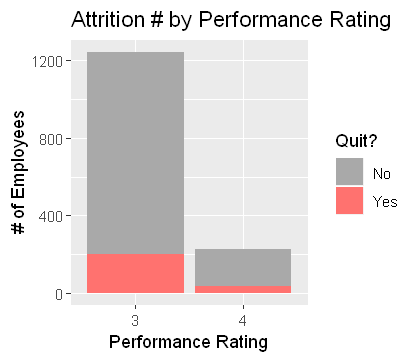

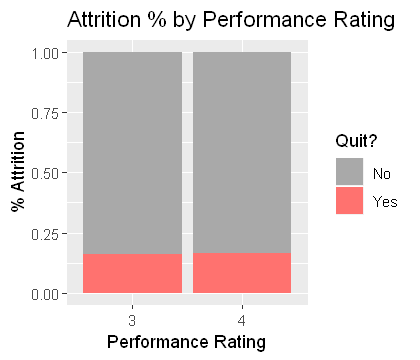

In [ ]:
# Create a bar plot that counts employees by performance rating and attrition.
ggplot(hr_data, aes(x=factor(PerformanceRating), fill = factor(Attrition))) +
    geom_bar() +
    ggtitle("Attrition # by Performance Rating") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    xlab("Performance Rating") + ylab("# of Employees")

# Create a bar plot that shows % attrition by performance rating.
ggplot(hr_data, aes(x=factor(PerformanceRating), fill = factor(Attrition))) +
    geom_bar(position = "fill") +
    ggtitle("Attrition % by Performance Rating") +
    scale_fill_manual(name = "Quit?", labels = c("No", "Yes"), values = c("#A9A9A9", "#FF726F")) + 
    xlab("Performance Rating") + ylab("% Attrition")

#### ADDITIONAL GRAPH: Showing the correlation between numeric variables.

Next, we want to evaluate the relationship that exists between our fields (columns) in the dataset -- their relationship to attrition (which we are trying to predict) and their relationship to each other.  The value for correlation is always between -1 and 1.  As the correlation gets closer to -1 or 1, the relationships between variables becomes stronger.  As it gets closer to 0, it becomes weaker.  This helps us (1) determine what might be highly correlation with attrition and (2) what might be highly correlated with another variable and thus duplicative.  This evaluation is important before we build our model.

Based on the results showing in our correlation matrix, most variables have a weak, negative relationship with attrition.  (The light blue color.)  In other words, as those values decrease, attrition probability tends to slightly increase.

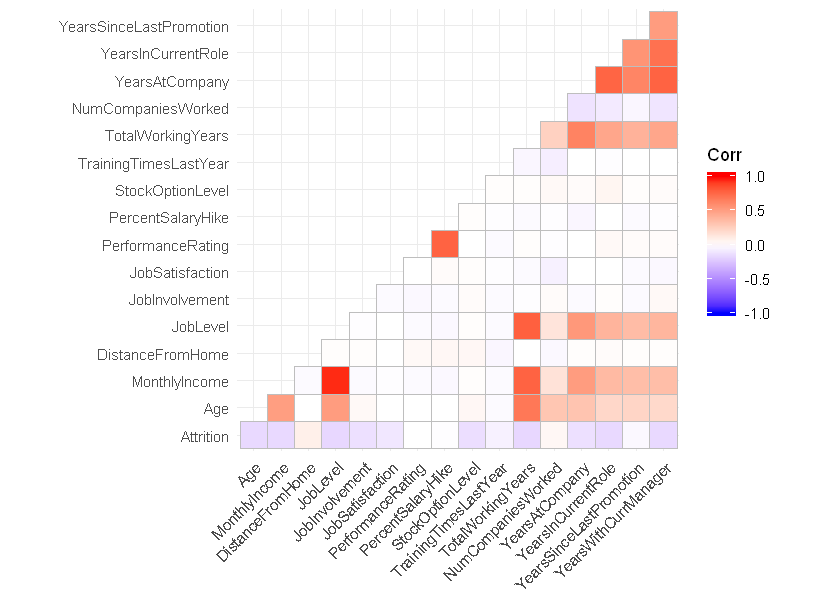

In [ ]:
# Calculate the correlation between numeric variables.
cor = cor(hr_data[c(1,3,8,12:25)])

# Plot the correlations on a matrix.  (Adjust/restore the default chart size.)
options(repr.plot.width=7, repr.plot.height=5)
ggcorrplot(cor, type="lower", tl.cex = 9)
options(repr.plot.width=3.5, repr.plot.height=3)

### Part 3: Prepare the data for modeling.

Prior to building our predictive model, we need to prep the data.  We first need to see if any rows in our dataset have missing values (as some machine learning algorithms need complete data in each row).  Next, we need to split our data into a training set (that will be used to build our model) and a test set (that will be used to evaluate how the model performs on real-world examples).

In [ ]:
# Determine if missing values exist.  If so, address them.
sum(is.na(hr_data))
# hr_code_clean <- na.omit(hr_data)

[1] 0

In [ ]:
# Split the dataset into a training and test set.
set.seed(3456)
trainIndex <- createDataPartition(hr_data$Attrition, p = .8, list = FALSE, times = 1)
hr_train <- hr_data[ trainIndex,]
hr_test  <- hr_data[-trainIndex,]

### Part 4: Build and evaluate a model to predict attrition.

At this point, we can now begin to build and evaluate a model that will be used to make our attrition predictions.  We will use logistic regression to do so.  Once we build our model, we will evaluate how well it performs using the area under the ROC curve (AUC) -- a common evaluation technique in classification.

In [ ]:
# Buid a model using logistic regression with all independent variables.
hr_model_lr_1 <- glm(Attrition ~ ., data=hr_train, family=binomial)
summary(hr_model_lr_1)


Call:
glm(formula = Attrition ~ ., family = binomial, data = hr_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6846  -0.5176  -0.2854  -0.0960   3.3513  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -1.264e+01  4.206e+02  -0.030  0.97603    
EmployeeNumber                   -1.498e-04  1.612e-04  -0.929  0.35278    
Age                              -3.669e-02  1.448e-02  -2.534  0.01127 *  
GenderMale                        4.078e-01  1.954e-01   2.087  0.03689 *  
MaritalStatusMarried              1.889e-01  2.836e-01   0.666  0.50532    
MaritalStatusSingle               9.045e-01  3.658e-01   2.473  0.01341 *  
DepartmentResearch & Development  1.232e+01  4.206e+02   0.029  0.97662    
DepartmentSales                   1.206e+01  4.206e+02   0.029  0.97713    
JobRoleHuman Resources            1.336e+01  4.206e+02   0.032  0.97467    
JobRoleLaboratory Technician      1.383

**Based on the output of our initial logistic regression model (shown above), which includes all possible independent variables, we can make decisions about which variables to remove.**  (A simple model is easier to understand and is less likely to "overfit" the training data.)  We can remove those variables which are NOT statistically significant.  In other words, the ones that have a p-value greater than 0.5.  (See the "Pr(>|z|)" column above.)

In [ ]:
# Buid a model using logistic regression with only statistically-significant variables.
hr_model_lr_2 <- glm(Attrition ~ 
                     Age + 
                     BusinessTravel + 
                     DistanceFromHome + 
                     Gender + 
                     JobInvolvement + 
                     JobRole + 
                     JobSatisfaction +
                     MaritalStatus + 
                     NumCompaniesWorked + 
                     OverTime + 
                     TrainingTimesLastYear + 
                     YearsInCurrentRole +
                     YearsSinceLastPromotion +
                     YearsWithCurrManager,
                   data=hr_train, family=binomial)
summary(hr_model_lr_2)


Call:
glm(formula = Attrition ~ Age + BusinessTravel + DistanceFromHome + 
    Gender + JobInvolvement + JobRole + JobSatisfaction + MaritalStatus + 
    NumCompaniesWorked + OverTime + TrainingTimesLastYear + YearsInCurrentRole + 
    YearsSinceLastPromotion + YearsWithCurrManager, family = binomial, 
    data = hr_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7521  -0.5367  -0.2913  -0.1097   3.7687  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.93978    0.86650  -1.085 0.278112    
Age                             -0.04605    0.01239  -3.716 0.000203 ***
BusinessTravelTravel_Frequently  1.69051    0.42460   3.981 6.85e-05 ***
BusinessTravelTravel_Rarely      1.00217    0.39430   2.542 0.011034 *  
DistanceFromHome                 0.04232    0.01120   3.777 0.000159 ***
GenderMale                       0.39752    0.19249   2.065 0.038914 *  
JobInvolvement                  -0

**After the update to the model, we still have a long list of variables.  We would like to reduce it further, if possible, without significantally hindering the model's predictive power.** So, next, we will use an R function ("varImp") that shows us how important each variable is within the model.  We can explore removing variables that are less important than others.

In [ ]:
# Evaluate the importance of independent variables that remain.
importance <- as.data.frame(varImp(hr_model_lr_2))
importance <- data.frame(Importance = importance$Overall, Field = rownames(importance))
importance <- importance[order(-importance$Importance),]
importance

,Importance,Field
19,8.7163514,OverTimeYes
17,4.7752031,MaritalStatusSingle
15,4.6690421,JobSatisfaction
22,4.2480250,YearsSinceLastPromotion
6,4.1525497,JobInvolvement
18,4.1074045,NumCompaniesWorked
2,3.9814357,BusinessTravelTravel_Frequently
4,3.7771078,DistanceFromHome
14,3.7261602,JobRoleSales Representative
1,3.7156271,Age


In [ ]:
# Buid a model using logistic regression with the smallest subset of variables.
hr_model_lr_2 <- glm(Attrition ~
                     JobInvolvement +
                     JobRole +
                     JobSatisfaction +
                     MaritalStatus + 
                     OverTime,
                   data=hr_train, family=binomial)
summary(hr_model_lr_2)


Call:
glm(formula = Attrition ~ JobInvolvement + JobRole + JobSatisfaction + 
    MaritalStatus + OverTime, family = binomial, data = hr_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0834  -0.5923  -0.3662  -0.1907   3.0749  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.51195    0.53717  -2.815  0.00488 ** 
JobInvolvement                -0.45917    0.11784  -3.896 9.76e-05 ***
JobRoleHuman Resources         1.66916    0.53337   3.129  0.00175 ** 
JobRoleLaboratory Technician   1.58656    0.40237   3.943 8.05e-05 ***
JobRoleManager                -0.85397    0.70907  -1.204  0.22845    
JobRoleManufacturing Director -0.25479    0.54264  -0.470  0.63869    
JobRoleResearch Director      -1.04247    0.81777  -1.275  0.20239    
JobRoleResearch Scientist      0.72938    0.41003   1.779  0.07527 .  
JobRoleSales Executive         0.96785    0.40169   2.409  0.01598 *  
JobRoleSales Rep

**Now that we have models constructed, we will make predictions in the test data using both models.  After that, we will compare the models using the area under the ROC curve (AUC).**  Assuming the performance of the models are close, we will elect to go with the simpler model.

In [ ]:
# Make predictions in the test data using the model with all variables; preview a few records.
hr_test$Attrition_prediction_lr_1 <- predict(hr_model_lr_1, newdata=hr_test, type='response')
print(head(hr_test[c("Attrition","Attrition_prediction_lr_1")]))

   Attrition Attrition_prediction_lr_1
4          0               0.270775781
9          0               0.084005782
19         0               0.003907404
20         0               0.355255955
31         0               0.210267355
32         0               0.058235933


In [ ]:
# Make predictions in the test data using the model with limited variables; preview a few records.
hr_test$Attrition_prediction_lr_2 <- predict(hr_model_lr_2, newdata=hr_test, type='response')
print(head(hr_test[c("Attrition","Attrition_prediction_lr_2")]))

   Attrition Attrition_prediction_lr_2
4          0                0.20877514
9          0                0.07231510
19         0                0.01196463
20         0                0.31968803
31         0                0.18058637
32         0                0.08282201


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


[1] "AUC for Logistic Regression Model (all variables): 0.82 (red)"

[1] "AUC for Logistic Regression Model (limited variables): 0.78 (blue)"

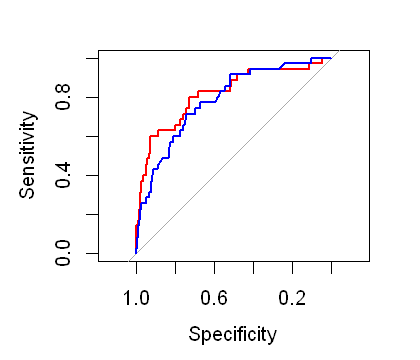

In [ ]:
# Evaluate the logistic regression models.

# Generate ROC curves for both version of the L.R. model.
ROC_lr_1 <- roc(hr_test$Attrition, hr_test$Attrition_prediction_lr_1)
ROC_lr_2 <- roc(hr_test$Attrition, hr_test$Attrition_prediction_lr_2)

# Print the AUC for both versions of the model
paste("AUC for Logistic Regression Model (all variables):", round(auc(ROC_lr_1),2), "(red)")
paste("AUC for Logistic Regression Model (limited variables):", round(auc(ROC_lr_2),2), "(blue)")

# Plot the ROC curves.
plot.roc(ROC_lr_1, col="red")
lines.roc(ROC_lr_2, col="blue")


**These results show that the simpler model (5 variables) performs nearly as well as the initial, more complex model (24 variables).  As such, we will elect to use the simpler model ("hr_model_lr_2").**